In [1]:
%%javascript
$(document).ready(() => {
    // Удаление данного блока кода с конечного результата.
    $('div.code_cell').first().css('display', 'none');

    // Включение автоматического переноса слов в параграфе.
    $('div.text_cell p').css('hyphens', 'auto');

    // Включение растягивания текста на всю доступную длину.
    $('div.text_cell p').css('text-align', 'justify');
});

<IPython.core.display.Javascript object>

<h3><b>Лабораторная работа №2: Логистическая регрессия</b></h3>

<p lang="ru">Логистическая регрессия — это статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём подгонки данных к логистической кривой. Логистическая регрессия применяется для прогнозирования вероятности возникновения некоторого события по значениям множества признаков. Для этого вводится так называемая зависимая переменная $y$, принимающая лишь одно из двух значений — как правило, это числа ноль (событие не произошло) и один (событие произошло), и множество некоторых независимых переменных, на основе значений которых требуется вычислить вероятность принятия того или иного значения зависимой переменной.</p>

In [2]:
%autosave 300

Autosaving every 300 seconds


In [3]:
import warnings

# Игнорирование некоторых оповещающих сообщений библиотек.
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
import numpy as np
import pandas as pd

In [5]:
# Импортирование дополнительных алгоритмов для оптимизации модели.
from scipy.optimize import fmin_l_bfgs_b, fmin_tnc, fmin_cg

In [6]:
# Импортирование функции для чтения MATLAB файлов.
from scipy.io import loadmat

In [7]:
# Импортирование библиотеки для работы с графиками.
from matplotlib import pyplot
%matplotlib inline

In [8]:
# Установка начального значения для генератора случайных чисел.
# Данное действие требуется для воспроизведения результатов опыта.
np.random.seed(0)

In [9]:
def extend_values(values):
    # Добавление единичного столбца в качестве значений смещения.
    return np.c_[(np.ones(values.shape[0]), values)]

<p lang="ru"><b>Пункт №1:&nbsp;</b>Загрузка первого предоставленного набора данных <tt>ex2data1.txt</tt> при помощи внешней библиотеки pandas. Текущий набор данных содержит информацию об оценке студента по первому экзамену, оценке по второму экзамену и о поступлении в университет.</p>

In [10]:
# Устанака имен столбцов для использования, так как файл не содержит строку заголовка.
data = pd.read_csv('./datasets/ex2data1.txt', names=['Exam1', 'Exam2', 'Admitted'])

<p lang="ru"><b>Пункт №2:&nbsp;</b>Построение графика зависимости поступления студента в университет от его оценок за экзамены. Всякую зависимость между двумя типами данных хорошо показывает диаграмма разброса значений. Ко всему прочему с помощью этой диаграммы можно определить корреляцию между каким-либо параметром качества и влияющим на него фактором.</p>

In [11]:
# Разделение данных на положительные и отрицательные.
pros = data[data['Admitted'] == 1][['Exam1', 'Exam2']]
cons = data[data['Admitted'] == 0][['Exam1', 'Exam2']]

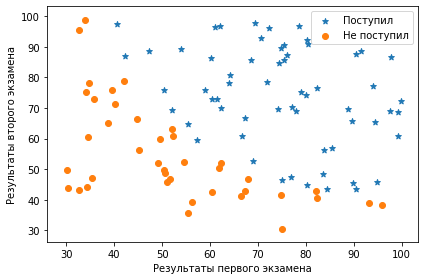

In [12]:
# Построение точечной диаграммы разброса данных.
pyplot.scatter(pros['Exam1'], pros['Exam2'], label='Поступил', marker='*')
pyplot.scatter(cons['Exam1'], cons['Exam2'], label='Не поступил', marker='o')

# Настройка координатных осей графика.
pyplot.xlabel('Результаты первого экзамена')
pyplot.ylabel('Результаты второго экзамена')

# Построение легенды графика.
pyplot.legend(loc='best')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

<p lang="ru"><b>Пункт №3:&nbsp;</b>Реализация функции стоимости модели для набора данных <tt>ex2data1.txt</tt> при помощи внешней библиотеки numpy. Данная функция выражает меру количества ошибок, которые рассматриваемая модель делает на наборе данных. Хоть и существуют различные функции стоимости, все они вычисляют расстояние между предсказанным и фактическим значением.</p>

In [13]:
def sigmoid(z):
    # Сигмоидальная функция активации.
    return np.power(1.0 + np.exp(-z), -1.0)

In [14]:
def h(w, x):
    # Функция вычисления вероятностных гепотиз.
    return sigmoid(np.dot(x, w))

In [15]:
def calc_cost(w, x, y, eps=1e-6):
    # Функция вычисления значения стоимости математической модели.
    return -np.sum(y * np.log(h(w, x)) + (1 - y) * np.log(1 - h(w, x) + eps)) / x.shape[0]

In [16]:
def calc_grad(w, x, y):
    # Функция вычисления градиента функции стоимости.
    return np.dot(x.T, h(w, x) - y) / x.shape[0]

In [17]:
def fmin_mgd(x0, fprime, args=(), alpha=0.05, beta_1=0.9, eps=1e-6):
    # Инициализация начального приближения.
    xx = x0[:]
    xi = x0[:]

    # Инициализация скользящих средних.
    velocity = 0

    funcalls = 1
    while True:
        # Вычисление значения градиента в данной точке.
        grad = fprime(xx, *args)

        # Обновление скользящих средних градиентов.
        velocity = beta_1 * velocity + (1 - beta_1) * grad

        # Пересчет значений параметров модели.
        xi = xx - alpha * velocity

        # Условие остановки алгоритма оптимизации.
        if np.sum(abs(xi - xx)) <= eps:
            break

        funcalls += 1
        xx = xi  # Обновите значения параметров на новые.

    return xx.ravel()

In [18]:
data_x = data[['Exam1', 'Exam2']].values
data_y = data[['Admitted']].values.ravel()

# Добавление дополнительных значений смещения.
data_x = extend_values(data_x)

In [19]:
# Инициализация начальных параметров модели.
prime = np.zeros(data_x.shape[1])

In [20]:
%%time

# Запуск оптимизации математической модели.
thetas = fmin_mgd(x0=prime, fprime=calc_grad, args=(data_x, data_y))

CPU times: user 9.1 s, sys: 19.4 ms, total: 9.12 s
Wall time: 9.2 s


<p lang="ru"><b>Пункт №4:&nbsp;</b>Реализация других методов оптимизации исходной математической модели. Для сравнения с градиентным спуском было выбрано несколько распространенных методов: алгоритм Ньютона и алгоритм Бройдена - Флетчера - Гольдфарба - Шанно. При проведении исследований было замечено, что выбранные методы работают намного быстрее методов, основанных на градиентном спуске, но их применение в больших моделях не целесообразно из-за асимптотической сложности этих алгоритмов.</p>

In [21]:
%%time

# Запуск оптимизации математической модели.
fmin_l_bfgs_b(func=calc_cost, x0=prime, fprime=calc_grad, args=(data_x, data_y))

CPU times: user 4.6 ms, sys: 1.11 ms, total: 5.71 ms
Wall time: 6.15 ms


(array([-25.16122243,   0.20623091,   0.20147064]),
 0.2034970072344874,
 {'grad': array([1.59553622e-07, 1.04649800e-05, 5.28846027e-06]),
  'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 38,
  'nit': 31,
  'warnflag': 0})

In [22]:
%%time

# Запуск оптимизации математической модели.
fmin_tnc(func=calc_cost, x0=prime, fprime=calc_grad, args=(data_x, data_y))

CPU times: user 6.23 ms, sys: 1.84 ms, total: 8.07 ms
Wall time: 8.6 ms


(array([-25.16131848,   0.20623159,   0.20147149]), 36, 0)

<p lang="ru"><b>Пункт №5:&nbsp;</b>Реализация функции предсказания вероятности поступления студента в зависимости от оценок по экзаменам. Проведение замеров точности обученной модели на исходных данных по заранее известным значениям.</p>

In [23]:
def calc_pred(w, x):
    # Функция вычисления вероятности класса.
    return np.where(h(w, x) >= 0.5, 1, 0)

In [24]:
# Вычисление точности обученной математической модели.
print('Значение точности:', np.mean(calc_pred(thetas, data_x) == data_y))

Значение точности: 0.89


<p lang="ru"><b>Пункт №6:&nbsp;</b>Построение полученной модели совместно с графиком зависимости поступления студента в университет от его оценок за экзамены. Данное действие необходимо для визуальной оценки корректности математической модели к обобщению данных.</p>

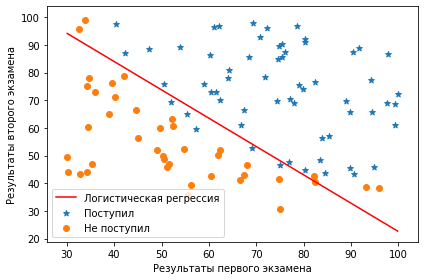

In [25]:
# Построение разделяющей линии полученной модели.
x = (data['Exam1'].min(), data['Exam1'].max())
y = (np.dot(thetas[1], x) + thetas[0]) * (-1 / thetas[2])
pyplot.plot(x, y, label='Логистическая регрессия', color='r')

# Построение точечной диаграммы разброса данных.
pyplot.scatter(pros['Exam1'], pros['Exam2'], label='Поступил', marker='*')
pyplot.scatter(cons['Exam1'], cons['Exam2'], label='Не поступил', marker='o')

# Настройка координатных осей графика.
pyplot.xlabel('Результаты первого экзамена')
pyplot.ylabel('Результаты второго экзамена')

# Построение легенды графика.
pyplot.legend(loc='best')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

***

<p lang="ru"><b>Пункт №7:&nbsp;</b>Загрузка второго предоставленного набора данных <tt>ex2data2.txt</tt> при помощи внешней библиотеки pandas. Текущий набор данных содержит информацию о результате первого и второго теста изделий и результате прохождения контроля качества.</p>

In [26]:
# Устанака имен столбцов для использования, так как файл не содержит строку заголовка.
data = pd.read_csv('./datasets/ex2data2.txt', names=['Test1', 'Test2', 'Admitted'])

<p lang="ru"><b>Пункт №8:&nbsp;</b>Построение графика зависимости прохождения изделием контроля качества от результатов его тестов. Всякую зависимость между двумя типами данных хорошо показывает диаграмма разброса значений. Ко всему прочему с помощью этой диаграммы можно определить корреляцию между каким-либо параметром качества и влияющим на него фактором.</p>

In [27]:
# Разделение данных на положительные и отрицательные.
pros = data[data['Admitted'] == 1][['Test1', 'Test2']]
cons = data[data['Admitted'] == 0][['Test1', 'Test2']]

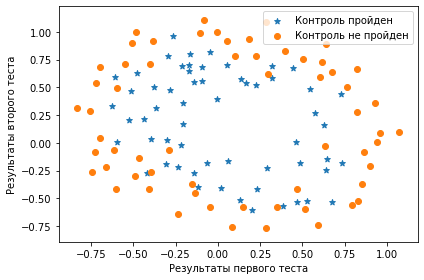

In [28]:
# Построение точечной диаграммы разброса данных.
pyplot.scatter(pros['Test1'], pros['Test2'], label='Контроль пройден', marker='*')
pyplot.scatter(cons['Test1'], cons['Test2'], label='Контроль не пройден', marker='o')

# Настройка координатных осей графика.
pyplot.xlabel('Результаты первого теста')
pyplot.ylabel('Результаты второго теста')

# Построение легенды графика.
pyplot.legend(loc='best')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

<p lang="ru"><b>Пункт №9:&nbsp;</b>Построение всех возможных комбинаций исходных признаков $x_{1}$ и $x_{2}$, в которых степень рассматриваемого полинома не превышает шести используя для этого формулу числа сочетаний. Данное действие позволит создать дополнительные признаки, которые помогут обучить модель обобщать нелинейные данные намного лучше.</p>

In [29]:
def create_feature_map(x0, x1, degree=6, verbose=False):
    x0 = np.array(x0)
    x1 = np.array(x1)

    # Создание вектора для накопления карты признаков.
    out_map = np.ones((x1.shape[0], 1))

    count = 0
    for i in range(1, degree + 1):
        for ii in range(i + 1):
            count += 1

            # Генерация нового признака.
            terms = np.power(x0, (i - ii)) * np.power(x1, ii)

            # Добавление нового признака в карту объектов.
            out_map = np.hstack((out_map, terms.reshape(x0.shape[0], 1))) 

            if verbose:
                print('X^{} * Y^{} ({})'.format(i - ii, i, count))

    return out_map

In [30]:
data_x = data[['Test1', 'Test2']].values
data_y = data[['Admitted']].values.ravel()

# Создание карты объектов с использованием доступных данных.
data_x = create_feature_map(data_x[:, 0], data_x[:, 1], verbose=True)

X^1 * Y^1 (1)
X^0 * Y^1 (2)
X^2 * Y^2 (3)
X^1 * Y^2 (4)
X^0 * Y^2 (5)
X^3 * Y^3 (6)
X^2 * Y^3 (7)
X^1 * Y^3 (8)
X^0 * Y^3 (9)
X^4 * Y^4 (10)
X^3 * Y^4 (11)
X^2 * Y^4 (12)
X^1 * Y^4 (13)
X^0 * Y^4 (14)
X^5 * Y^5 (15)
X^4 * Y^5 (16)
X^3 * Y^5 (17)
X^2 * Y^5 (18)
X^1 * Y^5 (19)
X^0 * Y^5 (20)
X^6 * Y^6 (21)
X^5 * Y^6 (22)
X^4 * Y^6 (23)
X^3 * Y^6 (24)
X^2 * Y^6 (25)
X^1 * Y^6 (26)
X^0 * Y^6 (27)


<p lang="ru"><b>Пункт №10:&nbsp;</b>Реализация гребневой регуляризации для логистической регрессии и обучение ее на расширенном наборе признаков исходных данных. Регуляризация подразумевает собой добавление некоторых дополнительных ограничений к условию с целью решить некорректно поставленную задачу или предотвратить переобучение. Эта информация часто имеет вид штрафа за сложность модели. Например, это могут быть ограничения гладкости результирующей функции или ограничения по норме векторного пространства.</p>

In [31]:
def calc_cost(w, x, y, l2=0.01, eps=1e-6):
    # Вычисление значения функции стоимости.
    cost = -np.sum(y * np.log(h(w, x)) + (1 - y) * np.log(1 - h(w, x) + eps)) / x.shape[0]

    # Вычисление значения регуляризации.
    reg = l2 / (2 * x.shape[0]) * np.sum(np.square(w))

    # Вычисление значения стоимости модели с учетом регуляризации.
    return cost + reg

In [32]:
def calc_grad(w, x, y, l2=0.01):
    # Функция вычисления градиента функции стоимости.
    return np.dot(x.T, h(w, x) - y) / x.shape[0] + (l2 / x.shape[0]) * w

In [33]:
# Инициализация начальных параметров модели.
prime = np.zeros(data_x.shape[1])

In [34]:
%%time

# Запуск оптимизации математической модели.
thetas = fmin_mgd(x0=prime, fprime=calc_grad, args=(data_x, data_y))

CPU times: user 42.1 s, sys: 388 ms, total: 42.5 s
Wall time: 45.9 s


<p lang="ru"><b>Пункт №11:&nbsp;</b>Реализация других методов оптимизации исходной математической модели с учетом гребневой регуляризации. Для сравнения с градиентным спуском было выбрано несколько распространенных методов: алгоритм Ньютона и алгоритм Бройдена - Флетчера - Гольдфарба - Шанно. При проведении исследований было замечено, что выбранные методы работают намного быстрее методов, основанных на градиентном спуске, но их применение в больших моделях не целесообразно из-за асимптотической сложности этих алгоритмов.</p>

In [35]:
%%time

# Запуск оптимизации математической модели.
fmin_l_bfgs_b(func=calc_cost, x0=prime, fprime=calc_grad, args=(data_x, data_y))

CPU times: user 15.3 ms, sys: 3.1 ms, total: 18.4 ms
Wall time: 15.9 ms


(array([ 3.74543071,  2.01706556,  4.61544719, -5.4535081 , -6.66581153,
        -5.93561123,  2.14464386, -0.0982841 ,  2.44300723, -2.53462626,
        -3.80383019,  2.97631526, -3.7810916 , -1.95428944, -6.32384088,
        -1.73310577, -0.88123862,  5.01812187, -3.62326888, -4.34686219,
         2.86759868, -5.4602125 ,  0.4447596 , -0.87728573,  3.20741686,
        -4.50385798, -3.62186066,  0.26834252]),
 0.333252985148332,
 {'grad': array([ 7.46285694e-06, -2.02413198e-06,  8.46013045e-06,  3.03725166e-06,
         -4.57658404e-06,  5.36591305e-06, -2.87107983e-06,  3.71079329e-06,
         -8.31134362e-06,  5.20017180e-06,  9.18690694e-07, -2.57023048e-06,
         -4.14611285e-08, -2.13519956e-06,  5.21233633e-06, -2.83050321e-06,
         -5.64508747e-07, -2.62600435e-07,  1.92545335e-06, -6.53001367e-06,
          8.70514575e-06,  1.45305775e-06, -1.58181464e-06,  4.60912329e-07,
         -6.97313115e-07,  3.35208947e-07, -2.25071867e-06,  6.40339019e-06]),
  'task': b'CONVE

In [36]:
%%time

# Запуск оптимизации математической модели.
fmin_tnc(func=calc_cost, x0=prime, fprime=calc_grad, args=(data_x, data_y))

CPU times: user 10.3 ms, sys: 2.41 ms, total: 12.7 ms
Wall time: 10.7 ms


(array([ 3.74525074,  2.01045157,  4.61190542, -5.45534884, -6.67126419,
        -5.94054114,  2.15072264, -0.10185606,  2.46174317, -2.51519619,
        -3.80017909,  2.98376502, -3.77736232, -1.96497735, -6.31704081,
        -1.71961038, -0.86697795,  4.99859713, -3.62248077, -4.32581173,
         2.85446787, -5.47041269,  0.45191868, -0.88321592,  3.20881402,
        -4.50277384, -3.62851024,  0.26309933]), 89, 1)

<p lang="ru"><b>Пункт №12:&nbsp;</b>Реализация функции предсказания вероятности прохождения контроля изделием в зависимости от результатов тестов. Проведение замеров точности обученной модели на исходных данных по известным значениям.</p>

In [37]:
def calc_pred(w, x):
    # Функция вычисления вероятности класса.
    return np.where(h(w, x) >= 0.5, 1, 0)

In [38]:
# Вычисление точности обученной математической модели.
print('Значение точности:', np.mean(calc_pred(thetas, data_x) == data_y))

Значение точности: 0.8389830508474576


<p lang="ru"><b>Пункт №13:&nbsp;</b>Построение полученной математической модели совместно с графиком зависимости прохождения изделием контроля качества от результатов его тестов. Данное действие необходимо для визуальной оценки корректности математической модели к обобщению данных.</p>

In [39]:
def draw_decision_boundary(w, l2_param):
    x = np.linspace(-1, 1.5, 50)
    y = np.linspace(-1, 1.5, 50)

    z = np.zeros((x.shape[0], y.shape[0]))
    for i in range(x.shape[0]):
        for ii in range(y.shape[0]):
            z[i, ii] = create_feature_map([x[i]], [y[ii]]).dot(w)

    # Построение разделяющей линии полученной математической модели.
    pyplot.contour(x, y, z.T, 0)
    pyplot.contourf(x, y, z.T, 10)

    # Построение точечной диаграммы разброса данных.
    pyplot.scatter(pros['Test1'], pros['Test2'], label='Контроль пройден', marker='*')
    pyplot.scatter(cons['Test1'], cons['Test2'], label='Контроль не пройден', marker='o')

    # Настройка заглавия графика.
    pyplot.title('Регуляризация: {}'.format(l2_param))

    # Настройка координатных осей графика.
    pyplot.xlabel('Результаты первого теста')
    pyplot.ylabel('Результаты второго теста')

    # Построение легенды графика.
    pyplot.legend(loc='best')

    # Настройка отображения.
    pyplot.tight_layout()

    # Отображение графика.
    pyplot.show()

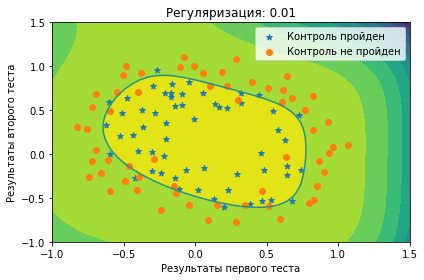

In [40]:
draw_decision_boundary(thetas, 0.01)

<p lang="ru"><b>Пункт №14:&nbsp;</b>Сравнения различных результатов обобщения модели, полученных путем изменения коэффициента регуляризации. По графикам можно заметить, что при очень больших значениях коэффициента, алгоритм начинает больше обучать значения регуляризации, чем параметры исходной математической модели, что ведет к переобучению.</p>

In [41]:
%%time

# Доступные коэффициенты регуляризации для сравнения.
l2_params = [0.01, 0.5, 1, 10, 100]

models = [
    # Запуск оптимизации математической модели.
    fmin_mgd(x0=prime, fprime=calc_grad, args=(data_x, data_y, l2_param))
    for l2_param in l2_params
]

CPU times: user 39.6 s, sys: 225 ms, total: 39.8 s
Wall time: 41.2 s


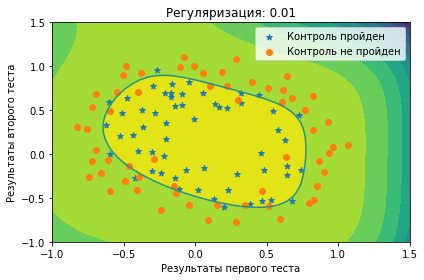

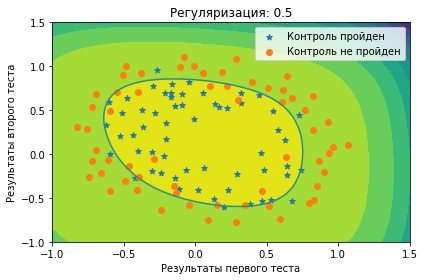

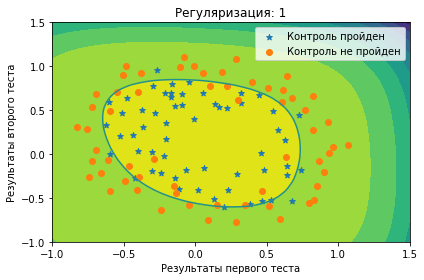

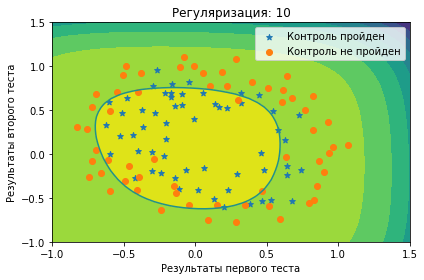

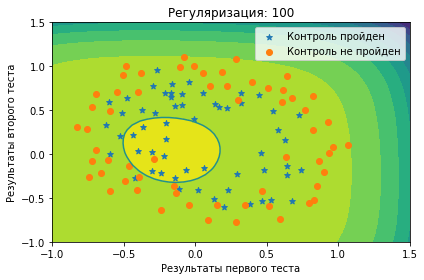

In [42]:
# Отрисовка модели с рассматриваемым коэффициентом регуляризации.
for model, l2_param in zip(models, l2_params):
    draw_decision_boundary(model, l2_param)

In [43]:
# Сравнение точности моделей, обученных с разными коэффициентами регуляризации.
for model, l2_param in zip(models, l2_params):
    print('Значение точности:', np.mean(calc_pred(model, data_x) == data_y))

Значение точности: 0.8389830508474576
Значение точности: 0.8220338983050848
Значение точности: 0.8220338983050848
Значение точности: 0.7457627118644068
Значение точности: 0.6016949152542372


***

<p lang="ru"><b>Пункт №15:&nbsp;</b>Загрузка третьего предоставленного набора данных <tt>ex2data3.mat</tt> при помощи внешней библиотеки scipy. Текущий набор данных содержит несколько тысяч изображений в оттенках серого. Каждый пиксель представляет собой значение яркости.</p>

In [44]:
data = loadmat('./datasets/ex2data3.mat')

In [45]:
data_x = np.array(data['X'])
data_y = np.array(data['y']).ravel()

In [46]:
# Замена метки 10 на 0 из-за проблем с индексацией массивов в MATLAB.
data_y[data_y == 10] = 0

<p lang="ru"><b>Пункт №16:&nbsp;</b>Визуализация нескольких цифр из исходного набора данных.</p>

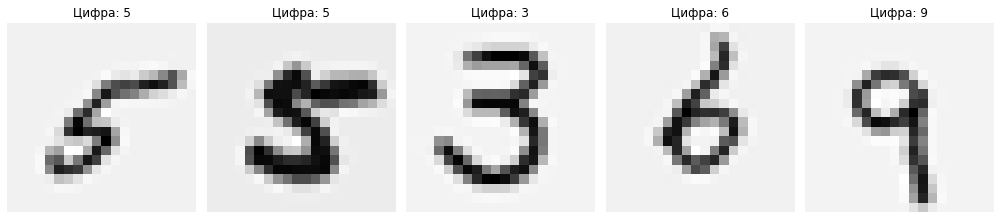

In [47]:
# Создание совместного полотна для графиков.
figure = pyplot.figure(figsize=(14, 4))

for num, index in enumerate(np.random.choice(data_x.shape[0], 5)):
    # Создание текущего полотна для графика.
    ax = figure.add_subplot(1, 5, num+1)

    # Визуализация рассматриваемой цифры.
    ax.imshow(data_x[index].reshape(20, 20, order='F'), cmap='binary')

    # Настройка заглавия графика.
    ax.set_title('Цифра: {}'.format(data_y[index]))

    # Отключение координатных осей.
    ax.axis('off')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show(figure)

<p lang="ru"><b>Пункт №17:&nbsp;</b>Реализация многоклассовой классификации по методу «один против всех». Метод позволяет учитывать сложность конкретной заданной задачи при построении композиции, эффективно определять оптимальный размер кодовой матрицы, не делая дополнительных предположений о данных. Такой подход основан на построении композиции классификаторов.</p>

In [48]:
# Добавление дополнительных значений смещения.
data_x = extend_values(data_x)

# Создание исходной модели.
model = np.zeros((10, data_x.shape[1]))

In [49]:
%%time

for i in range(10):
    # Инициализация начальных параметров модели.
    prime = np.zeros(data_x.shape[1])

    # Выделяем только тот класс, к которому относится рассматриваемая цифра.
    labels = (data_y == i).astype(int)

    # Запуск оптимизации математической модели.
    model[i, :] = fmin_cg(f=calc_cost, x0=prime, fprime=calc_grad, args=(data_x, labels), disp=0)

CPU times: user 1min 51s, sys: 6.45 s, total: 1min 58s
Wall time: 1min 26s


<p lang="ru"><b>Пункт №18:&nbsp;</b>Реализация функции предсказания вероятности класса для рукописной цифры на конкретном изображении. Проведение замеров точности обученной модели на исходных данных по известным значениям.</p>

In [50]:
def calc_pred(w, x):
    # Функция вычисления вероятности класса.
    return h(w.T, x).argmax(axis=1)

In [51]:
# Вычисление точности обученной математической модели.
print('Значение точности:', np.mean(calc_pred(model, data_x) == data_y))

Значение точности: 0.974
